In [4]:
# Exercise
# Use the given volatility quotes to
# (a) compute the call/put option strikes for ATM, 25 delta, 10 delta, 5 delta
# (b) plot the volatility points against strike
# Interpolation between vol points is not needed in the plot

# Volatility smile data:
# 3M vols are taken from Bloomberg screenshot in class notes
vols = {('ATM', 0): 7.090,
        ('RR', 25): -0.928, ('BF', 25): 0.195,
        ('RR', 10): -1.605, ('BF', 10): 0.607,
        ('RR', 5): -1.895, ('BF', 5): 0.902}

# Assumptions:
# EURUSD spot rate S0 = 1.15
# continuous compounded USD discount rate r = 0.04
# continuous compounded EUR discount rate r = 0.02
# time to option expiry = 3/12

Forward F = 1.155764
Smile points (label, strike, vol%):
5Δ Put      K=1.071512  vol=9.3500%
10Δ Put     K=1.093429  vol=8.8240%
25Δ Put     K=1.126045  vol=8.0090%
ATM         K=1.155764  vol=7.0900%
25Δ Call    K=1.184274  vol=7.0810%
10Δ Call    K=1.212319  vol=7.3660%
5Δ Call     K=1.230362  vol=7.5300%


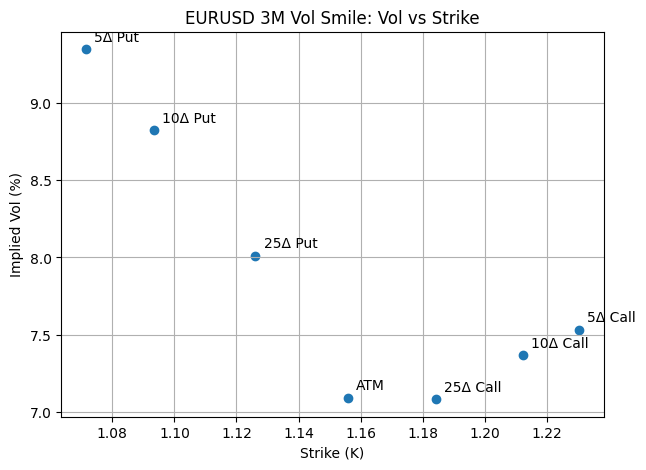

In [5]:
import math
import mpmath as mp
import matplotlib.pyplot as plt

# Given vols
vols = {('ATM', 0): 7.090,
        ('RR', 25): -0.928, ('BF', 25): 0.455,
        ('RR', 10): -1.458, ('BF', 10): 1.005,
        ('RR', 5): -1.820,  ('BF', 5): 1.350}

# Given inputs
S0 = 1.15
rd = 0.04   # domestic rate
rf = 0.02   # foreign rate
T = 3/12    # 3M

# ATM vol (%)
ATM = vols[('ATM', 0)]

# Forward price
F = S0 * math.exp((rd - rf) * T)

def inv_norm(p: float) -> float:
    return math.sqrt(2) * float(mp.erfinv(2*p - 1))

def vol_from_rr_bf(atm, rr, bf, is_call=True):
    # Market rule:
    # call vol = ATM + BF + RR/2
    # put  vol = ATM + BF - RR/2
    return atm + bf + (rr/2 if is_call else -rr/2)

def strike_from_spot_delta(delta_abs: float, sigma: float, is_call: bool) -> float:
    disc_f = math.exp(-rf * T)

    if is_call:
        p = delta_abs / disc_f
        d1 = inv_norm(p)
    else:
        p = delta_abs / disc_f
        d1 = -inv_norm(p)

    K = F * math.exp(-(d1 * sigma * math.sqrt(T) - 0.5 * sigma * sigma * T))
    return K

# Build smile points
points = []
points.append(("ATM", F, ATM))

for delta in [25, 10, 5]:
    rr = vols[('RR', delta)]
    bf = vols[('BF', delta)]

    vol_call = vol_from_rr_bf(ATM, rr, bf, is_call=True)
    vol_put  = vol_from_rr_bf(ATM, rr, bf, is_call=False)

    K_call = strike_from_spot_delta(delta/100, vol_call/100, is_call=True)
    K_put  = strike_from_spot_delta(delta/100, vol_put/100,  is_call=False)

    points.append((f"{delta}Δ Call", K_call, vol_call))
    points.append((f"{delta}Δ Put",  K_put,  vol_put))

# Print results
print(f"Forward F = {F:.6f}")
print("Smile points (label, strike, vol%):")
for lbl, K, v in sorted(points, key=lambda x: x[1]):
    print(f"{lbl:10s}  K={K:.6f}  vol={v:.4f}%")

# Plot
Ks = [K for _, K, _ in points]
Vs = [v for _, _, v in points]

plt.figure(figsize=(7,5))
plt.scatter(Ks, Vs)
for lbl, K, v in points:
    plt.annotate(lbl, (K, v), textcoords="offset points", xytext=(6, 6))
plt.xlabel("Strike (K)")
plt.ylabel("Implied Vol (%)")
plt.title("EURUSD 3M Vol Smile: Vol vs Strike")
plt.grid(True)
plt.show()
